# Project 4 DDPM with DIP prior


## Import library

In [2]:
import torch
import torch.nn as nn
import random
import numpy as np
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import pandas as pd

from torch.utils.data import DataLoader
from tqdm import tqdm
from skimage.color import rgb2lab, deltaE_ciede2000
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim, mean_squared_error as mse
from torchvision import datasets
from torchvision.datasets import STL10

c:\Users\kartg\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## 1.DDPM only

### A. Config

In [64]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 0.001
num_sub_blocks = 10
input_channels = 3  # For RGB images
num_epochs = 100

noise_levels = [0.01 * np.exp(-0.05 * i) for i in range(1000)] #exponential decay

#noise_levels = [0.01 * (1 - i / 1000) for i in range(1000)] #linear decay

#random.seed(42)
#noise_levels = [0.01 * random.uniform(0.5, 1.5) for _ in range(1000)] #random



### B. Prepare dataset(STL-10)

In [65]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # ImageNet's mean and std
])

training_set = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=transform)
train_dataloader = DataLoader(training_set, batch_size=32, shuffle=True)


Files already downloaded and verified


### C. Define DDPM

#### Forward process
在 DDPM 中，forward process 是將原始圖像逐漸添加隨機噪聲，最終生成純噪聲的過程。這個過程可以分為以下幾個步驟：

1. **原始圖像**：開始於一張清晰的原始圖像，例如一隻貓的照片。
2. **n次添加噪聲**：將一定程度的隨機噪聲添加到圖像中，使得圖像變得略微模糊。
3. **最終結果**：經過多次添加噪聲後，圖像最終變成純噪聲。

在這個過程中，每一步添加的噪聲都是根據一定的概率分布進行的，這樣可以保證過程的可逆性。在訓練階段，模型學習如何從噪聲中逐漸去除噪聲，從而恢復原始圖像。

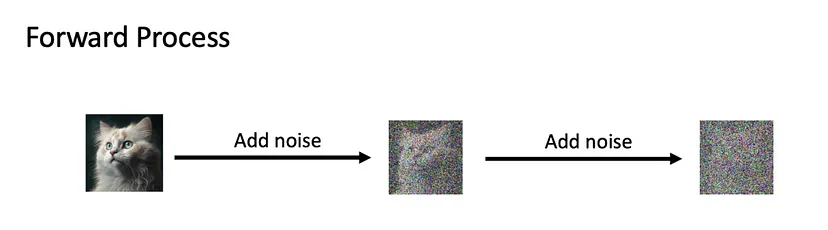

```python
class SubBlock(nn.Module):
        '
        '
        '
    def add_noise(self, x, sigma_t):
        noise = torch.randn_like(x) * sigma_t
        return x + noise

    def forward(self, x, t):
        sigma_t = self.noise_time_list[t]
        return self.add_noise(x, sigma_t) - self.network(x)

class DDPM(nn.Module):  
        '
        '
        '      
    def forward(self, x, t):
        return self.forward_process(x, t)
    
    def forward_process(self, x, t):
        for block in self.blocks:
            x = block(x, t)
        return x    


#### Reverse process
在 DDPM 中，reverse process 是從純噪聲逐漸去除隨機噪聲，最終恢復到原始圖像的過程。這個過程可以分為以下幾個步驟：

1. **純噪聲圖像**：開始於一張完全隨機的噪聲圖像。
2. **n次去除噪聲**：模型根據當前的噪聲水平預測並去除部分噪聲，使得圖像略微變得清晰。
3. **最終結果**：經過多次去除噪聲後，圖像逐漸恢復到接近原始的清晰圖像。

在這個過程中，每一步去除的噪聲都是通過模型預測的。模型在訓練階段學習如何從噪聲中逐步恢復原始圖像。

這個過程有助於模型學習如何從噪聲中重建原始圖像，最終可以在生成模型中應用。


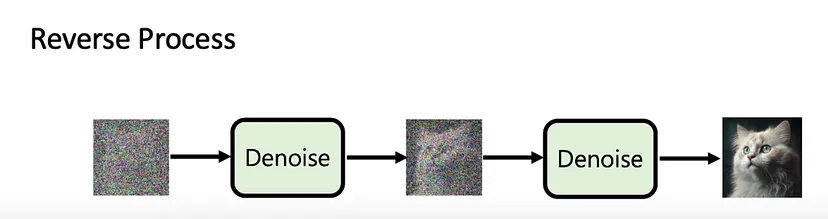

```python
class DDPM(nn.Module):
    def reverse_process(self, x, num_steps=1000):
        for t in tqdm(reversed(range(num_steps)), desc="Denoising"):
            for block in self.blocks:
                x = block(x, t)
        return x

#### Model Spec  
loss function: MSE  
optimizer: AdamW  



In [66]:
class SubBlock(nn.Module):
    def __init__(self, input_channels, noise_levels):
        super(SubBlock, self).__init__()
        self.noise_levels = nn.Parameter(torch.tensor(noise_levels), requires_grad=False)
        self.network = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, input_channels, kernel_size=5, padding=2),
            nn.BatchNorm2d(input_channels),
            
            #n.Conv2d(input_channels, 32, kernel_size=5, padding=2),
            #nn.BatchNorm2d(32),
            #nn.ReLU(),
            #nn.Conv2d(32, 64, kernel_size=5, padding=2),
            #nn.BatchNorm2d(64),
            #nn.ReLU(),
            #nn.Conv2d(64, 128, kernel_size=5, padding=2),
            #nn.BatchNorm2d(128),
            #nn.ReLU(),
            #nn.Conv2d(128, 64, kernel_size=5, padding=2),
            #nn.BatchNorm2d(64),
            #nn.ReLU(),
            #nn.Conv2d(64, 32, kernel_size=5, padding=2),
            #nn.BatchNorm2d(32),
            #nn.ReLU(),
            #nn.Conv2d(32, input_channels, kernel_size=5, padding=2),
            #nn.BatchNorm2d(input_channels)
        )

    def apply_noise(self, x, sigma_t):
        noise = torch.randn_like(x) * sigma_t
        return x + noise

    def forward(self, x, t):
        sigma_t = self.noise_levels[t]
        return self.apply_noise(x, sigma_t) - self.network(x)     

In [67]:
class DDPM(nn.Module):
    def __init__(self, num_sub_blocks, input_channels, noise_levels):
        super(DDPM, self).__init__()
        self.blocks = nn.ModuleList()
        for _ in range(num_sub_blocks):
            self.blocks.append(SubBlock(input_channels, noise_levels))

    def apply_forward_process(self, x, t):
        for block in self.blocks:
            x = block(x, t)
        return x
    
    def apply_reverse_process(self, x, steps=1000):
        for t in tqdm(reversed(range(steps)), desc="Denoising"):
            for block in self.blocks:
                x = block(x, t)
        return x

    '''
    def apply_reverse_process(self, x, steps):
        for t in tqdm(reversed(range(steps)), desc="Denoising"):
            t_step = torch.full((x.size(0),), t, dtype=torch.long, device=x.device)
            for block in self.blocks:
                x = block(x, t_step)
        return x
    '''

    def forward(self, x, t):
        return self.apply_forward_process(x, t)
        
def restored_image_func(model, input_image, num_iterations):
    model.eval()
    with torch.no_grad():
        x = input_image.unsqueeze(0).to(device)
        for _ in range(num_iterations):
            random_t = torch.randint(0, len(noise_levels), (1,)).item()
            x = model(x, t=random_t)
        return x.squeeze(0).cpu()

In [68]:
model = DDPM(num_sub_blocks, input_channels, noise_levels).to(device)
loss_function = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

### D. Training and Plot Loss

Epoch 1/100: 100%|██████████| 157/157 [00:05<00:00, 31.21it/s]


Epoch [1/100], Average Loss: 0.244344 



Epoch 2/100: 100%|██████████| 157/157 [00:05<00:00, 31.25it/s]


Epoch [2/100], Average Loss: 0.020274 



Epoch 3/100: 100%|██████████| 157/157 [00:04<00:00, 32.51it/s]


Epoch [3/100], Average Loss: 0.008290 



Epoch 4/100: 100%|██████████| 157/157 [00:04<00:00, 33.21it/s]


Epoch [4/100], Average Loss: 0.004247 



Epoch 5/100: 100%|██████████| 157/157 [00:04<00:00, 33.96it/s]


Epoch [5/100], Average Loss: 0.002757 



Epoch 6/100: 100%|██████████| 157/157 [00:04<00:00, 34.12it/s]


Epoch [6/100], Average Loss: 0.002001 



Epoch 7/100: 100%|██████████| 157/157 [00:04<00:00, 34.06it/s]


Epoch [7/100], Average Loss: 0.001785 



Epoch 8/100: 100%|██████████| 157/157 [00:04<00:00, 34.29it/s]


Epoch [8/100], Average Loss: 0.001403 



Epoch 9/100: 100%|██████████| 157/157 [00:04<00:00, 31.55it/s]


Epoch [9/100], Average Loss: 0.001168 



Epoch 10/100: 100%|██████████| 157/157 [00:05<00:00, 29.35it/s]


Epoch [10/100], Average Loss: 0.001060 



Epoch 11/100: 100%|██████████| 157/157 [00:06<00:00, 26.16it/s]


Epoch [11/100], Average Loss: 0.000984 



Epoch 12/100: 100%|██████████| 157/157 [00:05<00:00, 26.24it/s]


Epoch [12/100], Average Loss: 0.000849 



Epoch 13/100: 100%|██████████| 157/157 [00:06<00:00, 24.59it/s]


Epoch [13/100], Average Loss: 0.000779 



Epoch 14/100: 100%|██████████| 157/157 [00:06<00:00, 25.01it/s]


Epoch [14/100], Average Loss: 0.000738 



Epoch 15/100: 100%|██████████| 157/157 [00:06<00:00, 25.75it/s]


Epoch [15/100], Average Loss: 0.000647 



Epoch 16/100: 100%|██████████| 157/157 [00:06<00:00, 25.93it/s]


Epoch [16/100], Average Loss: 0.000630 



Epoch 17/100: 100%|██████████| 157/157 [00:05<00:00, 27.29it/s]


Epoch [17/100], Average Loss: 0.000599 



Epoch 18/100: 100%|██████████| 157/157 [00:05<00:00, 26.79it/s]


Epoch [18/100], Average Loss: 0.000564 



Epoch 19/100: 100%|██████████| 157/157 [00:05<00:00, 27.06it/s]


Epoch [19/100], Average Loss: 0.000492 



Epoch 20/100: 100%|██████████| 157/157 [00:05<00:00, 27.05it/s]


Epoch [20/100], Average Loss: 0.000491 



Epoch 21/100: 100%|██████████| 157/157 [00:05<00:00, 27.21it/s]


Epoch [21/100], Average Loss: 0.000482 



Epoch 22/100: 100%|██████████| 157/157 [00:05<00:00, 27.24it/s]


Epoch [22/100], Average Loss: 0.000413 



Epoch 23/100: 100%|██████████| 157/157 [00:05<00:00, 27.44it/s]


Epoch [23/100], Average Loss: 0.000450 



Epoch 24/100: 100%|██████████| 157/157 [00:05<00:00, 27.11it/s]


Epoch [24/100], Average Loss: 0.000389 



Epoch 25/100: 100%|██████████| 157/157 [00:05<00:00, 27.58it/s]


Epoch [25/100], Average Loss: 0.000446 



Epoch 26/100: 100%|██████████| 157/157 [00:05<00:00, 27.83it/s]


Epoch [26/100], Average Loss: 0.000414 



Epoch 27/100: 100%|██████████| 157/157 [00:05<00:00, 27.08it/s]


Epoch [27/100], Average Loss: 0.000353 



Epoch 28/100: 100%|██████████| 157/157 [00:05<00:00, 27.87it/s]


Epoch [28/100], Average Loss: 0.000351 



Epoch 29/100: 100%|██████████| 157/157 [00:05<00:00, 27.37it/s]


Epoch [29/100], Average Loss: 0.000342 



Epoch 30/100: 100%|██████████| 157/157 [00:05<00:00, 26.75it/s]


Epoch [30/100], Average Loss: 0.000346 



Epoch 31/100: 100%|██████████| 157/157 [00:05<00:00, 27.96it/s]


Epoch [31/100], Average Loss: 0.000328 



Epoch 32/100: 100%|██████████| 157/157 [00:05<00:00, 27.83it/s]


Epoch [32/100], Average Loss: 0.000315 



Epoch 33/100: 100%|██████████| 157/157 [00:05<00:00, 26.91it/s]


Epoch [33/100], Average Loss: 0.000350 



Epoch 34/100: 100%|██████████| 157/157 [00:05<00:00, 27.61it/s]


Epoch [34/100], Average Loss: 0.000358 



Epoch 35/100: 100%|██████████| 157/157 [00:05<00:00, 26.91it/s]


Epoch [35/100], Average Loss: 0.000323 



Epoch 36/100: 100%|██████████| 157/157 [00:05<00:00, 27.11it/s]


Epoch [36/100], Average Loss: 0.000287 



Epoch 37/100: 100%|██████████| 157/157 [00:05<00:00, 27.53it/s]


Epoch [37/100], Average Loss: 0.000297 



Epoch 38/100: 100%|██████████| 157/157 [00:05<00:00, 26.69it/s]


Epoch [38/100], Average Loss: 0.000304 



Epoch 39/100: 100%|██████████| 157/157 [00:05<00:00, 27.00it/s]


Epoch [39/100], Average Loss: 0.000301 



Epoch 40/100: 100%|██████████| 157/157 [00:05<00:00, 27.52it/s]


Epoch [40/100], Average Loss: 0.000273 



Epoch 41/100: 100%|██████████| 157/157 [00:05<00:00, 26.97it/s]


Epoch [41/100], Average Loss: 0.000241 



Epoch 42/100: 100%|██████████| 157/157 [00:05<00:00, 27.71it/s]


Epoch [42/100], Average Loss: 0.000280 



Epoch 43/100: 100%|██████████| 157/157 [00:05<00:00, 27.41it/s]


Epoch [43/100], Average Loss: 0.000248 



Epoch 44/100: 100%|██████████| 157/157 [00:05<00:00, 26.98it/s]


Epoch [44/100], Average Loss: 0.000326 



Epoch 45/100: 100%|██████████| 157/157 [00:05<00:00, 27.54it/s]


Epoch [45/100], Average Loss: 0.000254 



Epoch 46/100: 100%|██████████| 157/157 [00:05<00:00, 27.09it/s]


Epoch [46/100], Average Loss: 0.000234 



Epoch 47/100: 100%|██████████| 157/157 [00:05<00:00, 27.18it/s]


Epoch [47/100], Average Loss: 0.000202 



Epoch 48/100: 100%|██████████| 157/157 [00:05<00:00, 28.61it/s]


Epoch [48/100], Average Loss: 0.000232 



Epoch 49/100: 100%|██████████| 157/157 [00:05<00:00, 27.92it/s]


Epoch [49/100], Average Loss: 0.000445 



Epoch 50/100: 100%|██████████| 157/157 [00:05<00:00, 27.78it/s]


Epoch [50/100], Average Loss: 0.000204 



Epoch 51/100: 100%|██████████| 157/157 [00:05<00:00, 27.80it/s]


Epoch [51/100], Average Loss: 0.000208 



Epoch 52/100: 100%|██████████| 157/157 [00:05<00:00, 26.99it/s]


Epoch [52/100], Average Loss: 0.000196 



Epoch 53/100: 100%|██████████| 157/157 [00:06<00:00, 25.41it/s]


Epoch [53/100], Average Loss: 0.000179 



Epoch 54/100: 100%|██████████| 157/157 [00:06<00:00, 26.12it/s]


Epoch [54/100], Average Loss: 0.000213 



Epoch 55/100: 100%|██████████| 157/157 [00:06<00:00, 26.10it/s]


Epoch [55/100], Average Loss: 0.000165 



Epoch 56/100: 100%|██████████| 157/157 [00:05<00:00, 26.87it/s]


Epoch [56/100], Average Loss: 0.000191 



Epoch 57/100: 100%|██████████| 157/157 [00:05<00:00, 26.60it/s]


Epoch [57/100], Average Loss: 0.000177 



Epoch 58/100: 100%|██████████| 157/157 [00:05<00:00, 26.61it/s]


Epoch [58/100], Average Loss: 0.000184 



Epoch 59/100: 100%|██████████| 157/157 [00:05<00:00, 27.35it/s]


Epoch [59/100], Average Loss: 0.000204 



Epoch 60/100: 100%|██████████| 157/157 [00:05<00:00, 26.33it/s]


Epoch [60/100], Average Loss: 0.000281 



Epoch 61/100: 100%|██████████| 157/157 [00:05<00:00, 27.12it/s]


Epoch [61/100], Average Loss: 0.000200 



Epoch 62/100: 100%|██████████| 157/157 [00:05<00:00, 27.05it/s]


Epoch [62/100], Average Loss: 0.000170 



Epoch 63/100: 100%|██████████| 157/157 [00:06<00:00, 25.83it/s]


Epoch [63/100], Average Loss: 0.000160 



Epoch 64/100: 100%|██████████| 157/157 [00:05<00:00, 27.47it/s]


Epoch [64/100], Average Loss: 0.000232 



Epoch 65/100: 100%|██████████| 157/157 [00:05<00:00, 27.70it/s]


Epoch [65/100], Average Loss: 0.000179 



Epoch 66/100: 100%|██████████| 157/157 [00:05<00:00, 26.84it/s]


Epoch [66/100], Average Loss: 0.000158 



Epoch 67/100: 100%|██████████| 157/157 [00:05<00:00, 27.54it/s]


Epoch [67/100], Average Loss: 0.000199 



Epoch 68/100: 100%|██████████| 157/157 [00:05<00:00, 27.01it/s]


Epoch [68/100], Average Loss: 0.000171 



Epoch 69/100: 100%|██████████| 157/157 [00:05<00:00, 27.19it/s]


Epoch [69/100], Average Loss: 0.000153 



Epoch 70/100: 100%|██████████| 157/157 [00:05<00:00, 27.78it/s]


Epoch [70/100], Average Loss: 0.000175 



Epoch 71/100: 100%|██████████| 157/157 [00:05<00:00, 26.91it/s]


Epoch [71/100], Average Loss: 0.000137 



Epoch 72/100: 100%|██████████| 157/157 [00:05<00:00, 27.46it/s]


Epoch [72/100], Average Loss: 0.000158 



Epoch 73/100: 100%|██████████| 157/157 [00:05<00:00, 27.77it/s]


Epoch [73/100], Average Loss: 0.000121 



Epoch 74/100: 100%|██████████| 157/157 [00:05<00:00, 26.84it/s]


Epoch [74/100], Average Loss: 0.000283 



Epoch 75/100: 100%|██████████| 157/157 [00:05<00:00, 27.90it/s]


Epoch [75/100], Average Loss: 0.000138 



Epoch 76/100: 100%|██████████| 157/157 [00:05<00:00, 27.70it/s]


Epoch [76/100], Average Loss: 0.000144 



Epoch 77/100: 100%|██████████| 157/157 [00:05<00:00, 26.47it/s]


Epoch [77/100], Average Loss: 0.000211 



Epoch 78/100: 100%|██████████| 157/157 [00:05<00:00, 27.61it/s]


Epoch [78/100], Average Loss: 0.000117 



Epoch 79/100: 100%|██████████| 157/157 [00:05<00:00, 27.63it/s]


Epoch [79/100], Average Loss: 0.000131 



Epoch 80/100: 100%|██████████| 157/157 [00:05<00:00, 26.74it/s]


Epoch [80/100], Average Loss: 0.000111 



Epoch 81/100: 100%|██████████| 157/157 [00:05<00:00, 27.68it/s]


Epoch [81/100], Average Loss: 0.000106 



Epoch 82/100: 100%|██████████| 157/157 [00:05<00:00, 27.23it/s]


Epoch [82/100], Average Loss: 0.000116 



Epoch 83/100: 100%|██████████| 157/157 [00:05<00:00, 27.55it/s]


Epoch [83/100], Average Loss: 0.000124 



Epoch 84/100: 100%|██████████| 157/157 [00:05<00:00, 27.52it/s]


Epoch [84/100], Average Loss: 0.000243 



Epoch 85/100: 100%|██████████| 157/157 [00:05<00:00, 27.14it/s]


Epoch [85/100], Average Loss: 0.000113 



Epoch 86/100: 100%|██████████| 157/157 [00:05<00:00, 27.91it/s]


Epoch [86/100], Average Loss: 0.000096 



Epoch 87/100: 100%|██████████| 157/157 [00:05<00:00, 27.63it/s]


Epoch [87/100], Average Loss: 0.000098 



Epoch 88/100: 100%|██████████| 157/157 [00:05<00:00, 27.11it/s]


Epoch [88/100], Average Loss: 0.000097 



Epoch 89/100: 100%|██████████| 157/157 [00:05<00:00, 27.64it/s]


Epoch [89/100], Average Loss: 0.000104 



Epoch 90/100: 100%|██████████| 157/157 [00:05<00:00, 27.52it/s]


Epoch [90/100], Average Loss: 0.000096 



Epoch 91/100: 100%|██████████| 157/157 [00:05<00:00, 26.71it/s]


Epoch [91/100], Average Loss: 0.000109 



Epoch 92/100: 100%|██████████| 157/157 [00:05<00:00, 27.65it/s]


Epoch [92/100], Average Loss: 0.000105 



Epoch 93/100: 100%|██████████| 157/157 [00:05<00:00, 27.80it/s]


Epoch [93/100], Average Loss: 0.000135 



Epoch 94/100: 100%|██████████| 157/157 [00:05<00:00, 27.03it/s]


Epoch [94/100], Average Loss: 0.000096 



Epoch 95/100: 100%|██████████| 157/157 [00:05<00:00, 27.59it/s]


Epoch [95/100], Average Loss: 0.000099 



Epoch 96/100: 100%|██████████| 157/157 [00:05<00:00, 27.01it/s]


Epoch [96/100], Average Loss: 0.000117 



Epoch 97/100: 100%|██████████| 157/157 [00:05<00:00, 27.59it/s]


Epoch [97/100], Average Loss: 0.000227 



Epoch 98/100: 100%|██████████| 157/157 [00:05<00:00, 27.34it/s]


Epoch [98/100], Average Loss: 0.000082 



Epoch 99/100: 100%|██████████| 157/157 [00:05<00:00, 26.20it/s]


Epoch [99/100], Average Loss: 0.000085 



Epoch 100/100: 100%|██████████| 157/157 [00:05<00:00, 27.18it/s]


Epoch [100/100], Average Loss: 0.000079 



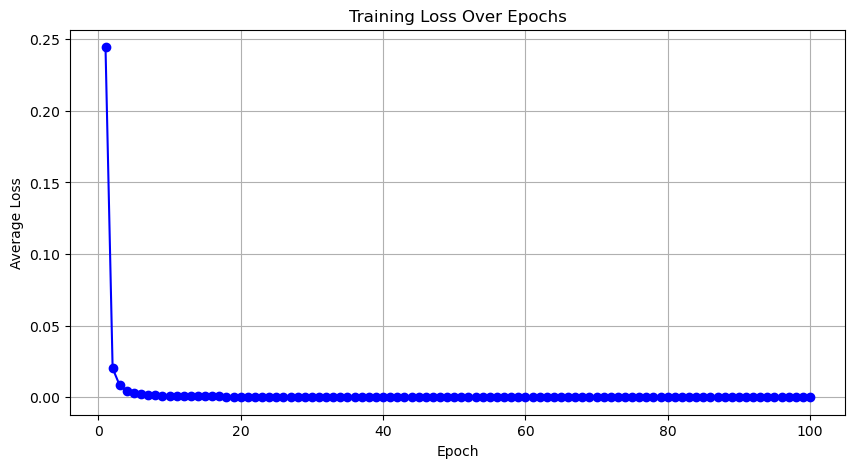

In [69]:
losses = []
model.train()

for epoch_num in range(num_epochs):
    total_loss = 0.0
    for batch_data in tqdm(train_dataloader, desc=f"Epoch {epoch_num+1}/{num_epochs}"):
        input_data = batch_data[0].to(device)
        optimizer.zero_grad()
        time_step = torch.randint(0, len(noise_levels), (1,)).item()
        predicted_output = model(input_data, t=time_step)
        loss_value = loss_function(predicted_output, input_data)
        loss_value.backward()
        optimizer.step()
        total_loss += loss_value.item()
    
    average_loss = total_loss / len(train_dataloader)
    losses.append(average_loss)
    print(f"Epoch [{epoch_num+1}/{num_epochs}], Average Loss: {average_loss:.6f} \n")

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), losses, marker='o', linestyle='-', color='b')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.show()

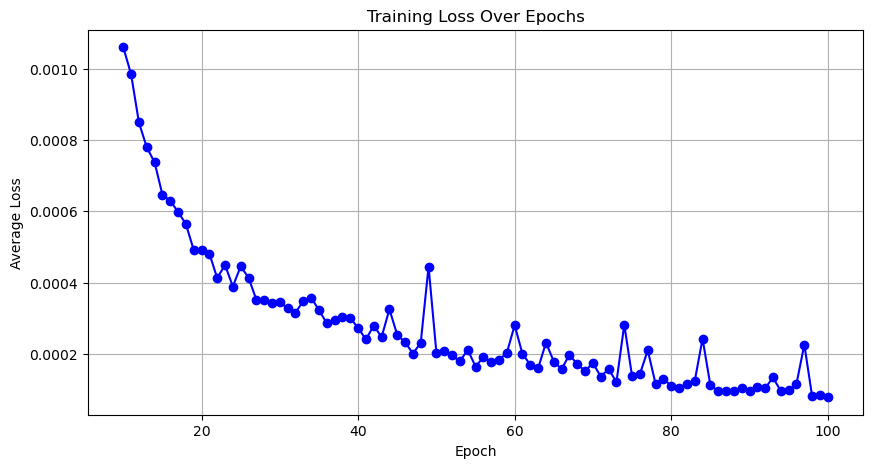

In [70]:
start_epoch = 10
plt.figure(figsize=(10, 5))
plt.plot(range(start_epoch, num_epochs + 1), losses[start_epoch - 1:], marker='o', linestyle='-', color='b')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.show()

#### E. Evaluation

在這部分，我們將評估模型在多個測試圖像上的性能。我們會使用去噪後的圖像來計算以下指標。

##### PSNR（Peak Signal-to-Noise Ratio）
PSNR 是一種基於像素誤差的圖像質量評價指標。它通過計算去噪圖像和原始圖像之間的均方誤差（MSE）來衡量圖像的質量。PSNR 的單位是分貝（dB），數值越大表示圖像質量越好。

##### SSIM（Structural Similarity Index）
SSIM 是一種更接近人類視覺系統的圖像質量評價指標。它通過比較兩幅圖像的亮度、對比度和結構來衡量圖像的相似性。SSIM 的取值範圍在[-1, 1]之間，數值越接近1表示圖像質量越好。

##### MSE（Mean Squared Error）
MSE 是一種基於像素誤差的圖像質量評估指標。它通過計算去噪圖像和原始圖像之間每個像素的差值平方和的平均值來衡量圖像的質量。MSE 值越小，表示去噪圖像與原始圖像之間的差異越小，圖像質量越好。

##### MAE（Mean Absolute Error）
MAE 是一種計算去噪圖像和原始圖像之間每個像素絕對差值的平均值的圖像質量評估指標。MAE 值越小，表示去噪圖像與原始圖像之間的差異越小，圖像質量越好。

##### Delta E（ΔE）
Delta E 是一種用於評估兩種顏色之間差異的指標。它基於 CIE Lab* 色彩空間，通過計算去噪圖像和原始圖像之間顏色差異來衡量圖像的質量。Delta E 值越小，表示去噪圖像與原始圖像之間的顏色差異越小，圖像質量越好。


Image 1 - PSNR: 42.1915, SSIM: 0.9981, MSE: 0.0001, MAE: 0.0062, Delta E: 1.4353


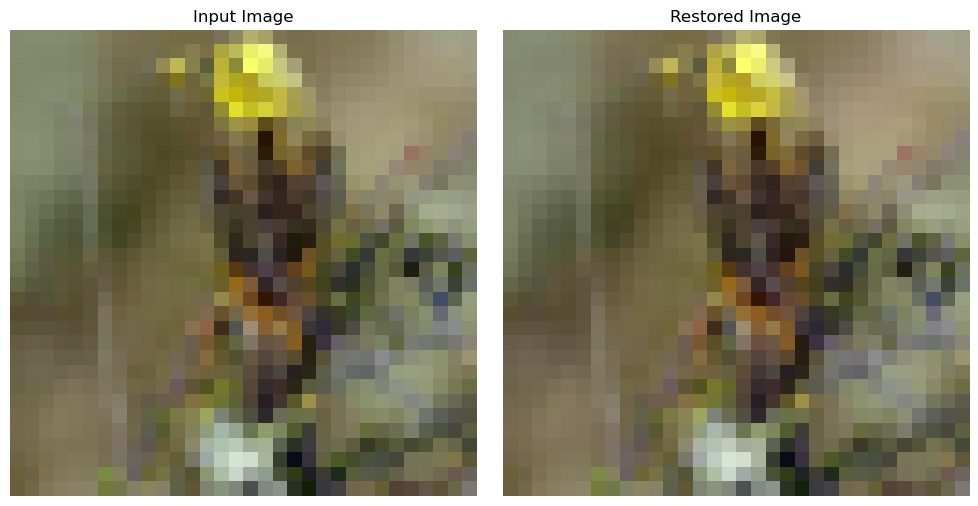

Image 2 - PSNR: 40.3233, SSIM: 0.9976, MSE: 0.0001, MAE: 0.0083, Delta E: 1.6563


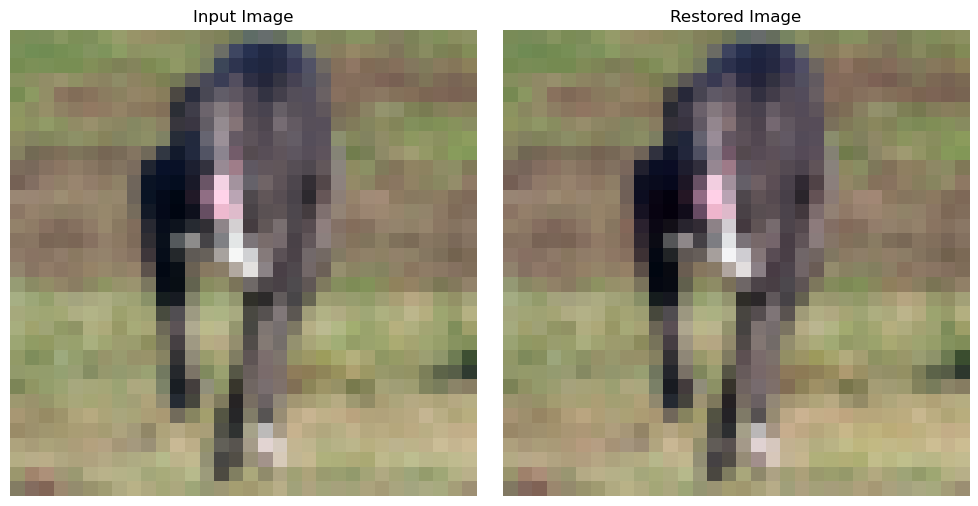

Image 3 - PSNR: 26.5428, SSIM: 0.9561, MSE: 0.0022, MAE: 0.0405, Delta E: 5.6217


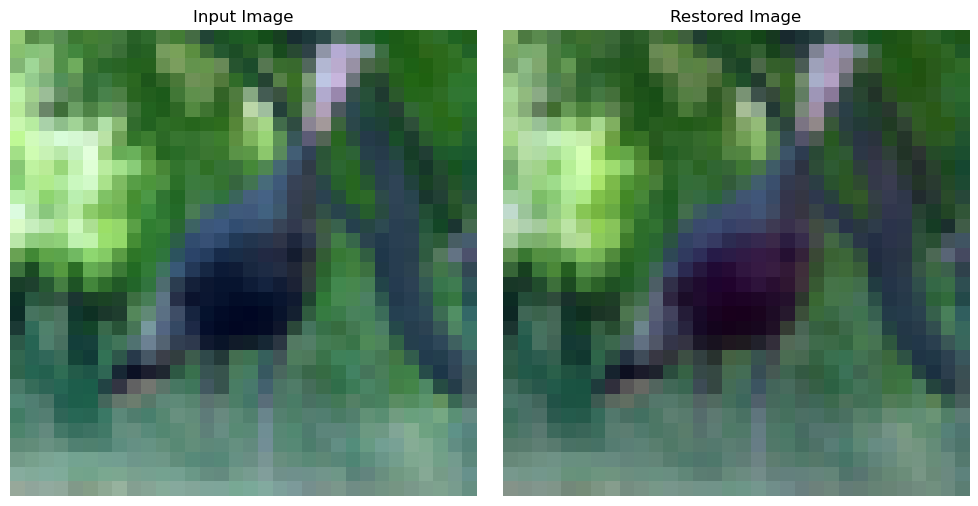

Image 4 - PSNR: 29.3655, SSIM: 0.9152, MSE: 0.0012, MAE: 0.0279, Delta E: 7.1989


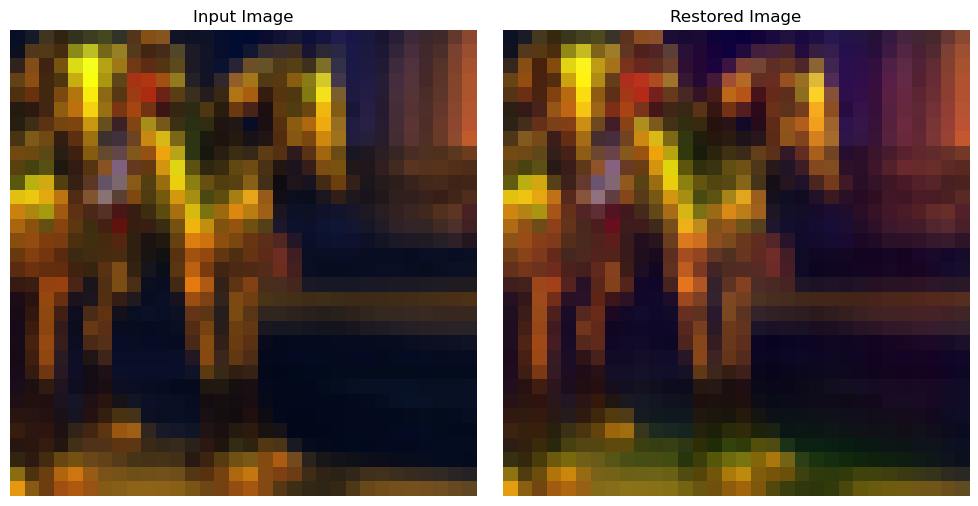

Image 5 - PSNR: 35.1278, SSIM: 0.9919, MSE: 0.0003, MAE: 0.0093, Delta E: 2.0367


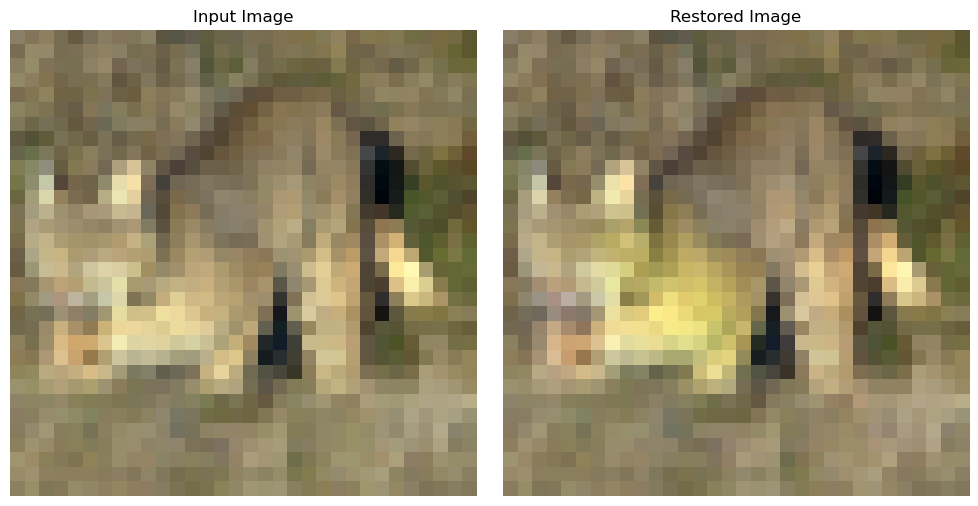

|    |   Image |    PSNR |     SSIM |         MSE |        MAE |   Delta E |
|---:|--------:|--------:|---------:|------------:|-----------:|----------:|
|  0 |       1 | 42.1915 | 0.99813  | 6.03747e-05 | 0.00621741 |   1.4353  |
|  1 |       2 | 40.3233 | 0.997566 | 9.28263e-05 | 0.00826082 |   1.65635 |
|  2 |       3 | 26.5428 | 0.956053 | 0.00221679  | 0.0404576  |   5.62169 |
|  3 |       4 | 29.3655 | 0.915224 | 0.00115731  | 0.0279156  |   7.19892 |
|  4 |       5 | 35.1278 | 0.991938 | 0.000307058 | 0.00930419 |   2.0367  |


Average PSNR: 34.7102
Average SSIM: 0.9718
Average MSE: 0.0008
Average MAE: 0.0184
Average Delta E: 3.5898


In [71]:
num_images = 5
psnr_values = []
ssim_values = []
mse_values = []
mae_values = []
deltaE_values = []
results = []

for i in range(num_images):
    test_image, _ = training_set[i]
    restored_image = restored_image_func(model, test_image, 10)

    test_image = (test_image - test_image.min()) / (test_image.max() - test_image.min())
    restored_image = (restored_image - restored_image.min()) / (restored_image.max() - restored_image.min())

    psnr_value = psnr(test_image.cpu().permute(1, 2, 0).numpy(),
                      restored_image.cpu().permute(1, 2, 0).numpy(), data_range=1.0)
    psnr_values.append(psnr_value)

    ssim_value = ssim(test_image.cpu().permute(1, 2, 0).numpy(),
                      restored_image.cpu().permute(1, 2, 0).numpy(), multichannel=True, win_size=3, data_range=1.0)
    ssim_values.append(ssim_value)

    mse_value = mse(test_image.cpu().permute(1, 2, 0).numpy(),
                    restored_image.cpu().permute(1, 2, 0).numpy())
    mse_values.append(mse_value)

    mae_value = torch.mean(torch.abs(test_image - restored_image)).item()
    mae_values.append(mae_value)

    test_image_lab = rgb2lab(test_image.cpu().permute(1, 2, 0).numpy())
    restored_image_lab = rgb2lab(restored_image.cpu().permute(1, 2, 0).numpy())
    deltaE_value = np.mean(deltaE_ciede2000(test_image_lab, restored_image_lab))
    deltaE_values.append(deltaE_value)

    print(f"Image {i+1} - PSNR: {psnr_value:.4f}, SSIM: {ssim_value:.4f}, MSE: {mse_value:.4f}, MAE: {mae_value:.4f}, Delta E: {deltaE_value:.4f}")
    

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Input Image')
    plt.axis('off')
    plt.imshow(test_image.permute(1, 2, 0))


    plt.subplot(1, 2, 2)
    plt.title('Restored Image')
    plt.axis('off')
    plt.imshow(restored_image.permute(1, 2, 0))

    plt.tight_layout()
    plt.show()

    results.append({
        "Image": i + 1,
        "PSNR": psnr_value,
        "SSIM": ssim_value,
        "MSE": mse_value,
        "MAE": mae_value,
        "Delta E": deltaE_value
    })

average_psnr = np.mean(psnr_values)
average_ssim = np.mean(ssim_values)
average_mse = np.mean(mse_values)
average_mae = np.mean(mae_values)
average_deltaE = np.mean(deltaE_values)

df = pd.DataFrame(results)

print(df.to_markdown())
print("\n")
print(f"Average PSNR: {average_psnr:.4f}")
print(f"Average SSIM: {average_ssim:.4f}")
print(f"Average MSE: {average_mse:.4f}")
print(f"Average MAE: {average_mae:.4f}")
print(f"Average Delta E: {average_deltaE:.4f}")

## 2.DDPM with DIP prior

### A. Config

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_channels = 3  # For RGB images
num_sub_blocks = 10

learning_rate_DIP = 0.001
learning_rate_DDPM = 0.001

num_epochs_DIP = 40
num_epochs_DDPM = 40

noise_levels = [0.01 * np.exp(-0.05 * i) for i in range(1000)] #exponential decay

#noise_levels = [0.01 * (1 - i / 1000) for i in range(1000)] #linear decay

#random.seed(42)
#noise_levels = [0.01 * random.uniform(0.5, 1.5) for _ in range(1000)] #random

### B. Prepare dataset(STL-10)

In [39]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # ImageNet's mean and std
])

training_set = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=transform)
train_dataloader = DataLoader(training_set, batch_size=32, shuffle=True)

Files already downloaded and verified


### C. DIP define
loss function: MSE  
optimizer: AdamW 

In [41]:
class DIP(nn.Module):
    def __init__(self, input_channels):
        super(DIP, self).__init__()
        self.network = nn.Sequential(
        nn.Conv2d(input_channels, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(64, input_channels, kernel_size=3, padding=1)
        )
    def forward(self, x):
        return self.network(x)
'''
    def __init__(self, channels):
        super(DIP, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        )

    def forward(self, x):
        return self.net(x)
'''

'\n    def __init__(self, channels):\n        super(DIP, self).__init__()\n        self.net = nn.Sequential(\n            nn.Conv2d(channels, channels, kernel_size=3, padding=1),\n            nn.ReLU(),\n            nn.Conv2d(channels, channels, kernel_size=3, padding=1)\n        )\n\n    def forward(self, x):\n        return self.net(x)\n'

In [42]:
DIP_model = DIP(input_channels).to(device)
DIP_loss_function = nn.MSELoss()
DIP_optimizer = optim.AdamW(DIP_model.parameters(), lr=learning_rate_DIP)

### D. DDPM define
loss function: MSE  
optimizer: AdamW 

In [43]:
class SubBlock(nn.Module):
    def __init__(self, input_channels, noise_levels):
        super(SubBlock, self).__init__()
        self.noise_levels = nn.Parameter(torch.tensor(noise_levels), requires_grad=False)
        self.network = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, input_channels, kernel_size=5, padding=2),
            nn.BatchNorm2d(input_channels),
            
            #n.Conv2d(input_channels, 32, kernel_size=5, padding=2),
            #nn.BatchNorm2d(32),
            #nn.ReLU(),
            #nn.Conv2d(32, 64, kernel_size=5, padding=2),
            #nn.BatchNorm2d(64),
            #nn.ReLU(),
            #nn.Conv2d(64, 128, kernel_size=5, padding=2),
            #nn.BatchNorm2d(128),
            #nn.ReLU(),
            #nn.Conv2d(128, 64, kernel_size=5, padding=2),
            #nn.BatchNorm2d(64),
            #nn.ReLU(),
            #nn.Conv2d(64, 32, kernel_size=5, padding=2),
            #nn.BatchNorm2d(32),
            #nn.ReLU(),
            #nn.Conv2d(32, input_channels, kernel_size=5, padding=2),
            #nn.BatchNorm2d(input_channels)
        )

    def apply_noise(self, x, sigma_t):
        noise = torch.randn_like(x) * sigma_t
        return x + noise

    def forward(self, x, t):
        sigma_t = self.noise_levels[t]
        return self.apply_noise(x, sigma_t) - self.network(x)     

In [44]:
class DDPM(nn.Module):
    def __init__(self, num_sub_blocks, input_channels, noise_levels):
        super(DDPM, self).__init__()
        self.blocks = nn.ModuleList()
        for _ in range(num_sub_blocks):
            self.blocks.append(SubBlock(input_channels, noise_levels))

    def apply_forward_process(self, x, t):
        for block in self.blocks:
            x = block(x, t)
        return x
    
    def apply_reverse_process(self, x, steps=1000):
        for t in tqdm(reversed(range(steps)), desc="Denoising"):
            for block in self.blocks:
                x = block(x, t)
        return x

    '''
    def apply_reverse_process(self, x, steps):
        for t in tqdm(reversed(range(steps)), desc="Denoising"):
            t_step = torch.full((x.size(0),), t, dtype=torch.long, device=x.device)
            for block in self.blocks:
                x = block(x, t_step)
        return x
    '''

    def forward(self, x, t):
        return self.apply_forward_process(x, t)
        
def restored_image_func(model, input_image, num_iterations):
    model.eval()
    with torch.no_grad():
        x = input_image.unsqueeze(0).to(device)
        for _ in range(num_iterations):
            random_t = torch.randint(0, len(noise_levels), (1,)).item()
            x = model(x, t=random_t)
        return x.squeeze(0).cpu()

In [45]:
DDPM_model = DDPM(num_sub_blocks, input_channels, noise_levels).to(device)
DDPM_loss_function = nn.MSELoss()
DDPM_optimizer = optim.AdamW(DDPM_model.parameters(), lr=learning_rate_DDPM)

### E. Training DIP and DDPM

In [46]:
losses_DIP = []
losses_DDPM = []
DIP_model.train()
DDPM_model.train()

for epoch_num in range(num_epochs_DIP + num_epochs_DDPM):
    if(epoch_num == 0): print("=======================DIP Training=======================\n")
    total_loss_DIP = 0.0
    total_loss_DDPM = 0.0
    if(epoch_num < num_epochs_DIP):
        for batch_data in tqdm(train_dataloader, desc=f"Epoch {epoch_num+1}/{num_epochs_DIP}"):
            target_image = batch_data[0].to(device)
            DIP_optimizer.zero_grad()
            output_image = DIP_model(target_image)
            loss_value = DIP_loss_function(output_image, target_image)
            loss_value.backward()
            DIP_optimizer.step()
            total_loss_DIP += loss_value.item()
        
        average_loss = total_loss_DIP / len(train_dataloader)
        losses_DIP.append(average_loss)
        print(f"Epoch [{epoch_num+1}/{num_epochs_DIP}], Average Loss: {average_loss:.6f} \n")
    else:
        if(epoch_num == num_epochs_DIP):
            print("=======================DDPM Training=======================\n")
        DIP_model.eval()
        for batch_data in tqdm(train_dataloader, desc=f"Epoch {epoch_num+1 - num_epochs_DIP}/{num_epochs_DDPM}"):
            input_data = batch_data[0].to(device)
            DDPM_optimizer.zero_grad()
            with torch.no_grad():
                DIP_output = DIP_model(input_data)
            
            time_step = torch.randint(0, len(noise_levels), (1,)).item()
            predicted_output = DDPM_model(DIP_output, t=time_step)
            loss_value = DDPM_loss_function(predicted_output, input_data)
            loss_value.backward()
            DDPM_optimizer.step()
            total_loss_DDPM += loss_value.item()
        average_loss = total_loss_DDPM / len(train_dataloader)
        losses_DDPM.append(average_loss)
        print(f"Epoch [{epoch_num+1 - num_epochs_DIP}/{num_epochs_DDPM}], Average Loss: {average_loss:.6f} \n")


=======================DIP Training====================



Epoch 1/40: 100%|██████████| 157/157 [00:02<00:00, 64.35it/s]


Epoch [1/40], Average Loss: 0.067399 



Epoch 2/40: 100%|██████████| 157/157 [00:01<00:00, 79.87it/s]


Epoch [2/40], Average Loss: 0.006708 



Epoch 3/40: 100%|██████████| 157/157 [00:01<00:00, 80.83it/s]


Epoch [3/40], Average Loss: 0.004320 



Epoch 4/40: 100%|██████████| 157/157 [00:01<00:00, 81.93it/s]


Epoch [4/40], Average Loss: 0.003179 



Epoch 5/40: 100%|██████████| 157/157 [00:01<00:00, 80.87it/s]


Epoch [5/40], Average Loss: 0.002660 



Epoch 6/40: 100%|██████████| 157/157 [00:01<00:00, 79.82it/s]


Epoch [6/40], Average Loss: 0.001873 



Epoch 7/40: 100%|██████████| 157/157 [00:01<00:00, 79.07it/s]


Epoch [7/40], Average Loss: 0.001707 



Epoch 8/40: 100%|██████████| 157/157 [00:01<00:00, 80.61it/s]


Epoch [8/40], Average Loss: 0.001448 



Epoch 9/40: 100%|██████████| 157/157 [00:02<00:00, 75.83it/s]


Epoch [9/40], Average Loss: 0.002265 



Epoch 10/40: 100%|██████████| 157/157 [00:01<00:00, 80.68it/s]


Epoch [10/40], Average Loss: 0.000976 



Epoch 11/40: 100%|██████████| 157/157 [00:01<00:00, 79.06it/s]


Epoch [11/40], Average Loss: 0.001187 



Epoch 12/40: 100%|██████████| 157/157 [00:02<00:00, 71.70it/s]


Epoch [12/40], Average Loss: 0.000795 



Epoch 13/40: 100%|██████████| 157/157 [00:01<00:00, 79.72it/s]


Epoch [13/40], Average Loss: 0.001458 



Epoch 14/40: 100%|██████████| 157/157 [00:01<00:00, 88.84it/s]


Epoch [14/40], Average Loss: 0.000649 



Epoch 15/40: 100%|██████████| 157/157 [00:01<00:00, 93.17it/s]


Epoch [15/40], Average Loss: 0.000636 



Epoch 16/40: 100%|██████████| 157/157 [00:02<00:00, 78.01it/s]


Epoch [16/40], Average Loss: 0.000699 



Epoch 17/40: 100%|██████████| 157/157 [00:02<00:00, 63.53it/s]


Epoch [17/40], Average Loss: 0.000738 



Epoch 18/40: 100%|██████████| 157/157 [00:02<00:00, 76.85it/s]


Epoch [18/40], Average Loss: 0.000726 



Epoch 19/40: 100%|██████████| 157/157 [00:02<00:00, 75.88it/s]


Epoch [19/40], Average Loss: 0.000622 



Epoch 20/40: 100%|██████████| 157/157 [00:02<00:00, 76.52it/s]


Epoch [20/40], Average Loss: 0.000750 



Epoch 21/40: 100%|██████████| 157/157 [00:02<00:00, 72.14it/s]


Epoch [21/40], Average Loss: 0.000497 



Epoch 22/40: 100%|██████████| 157/157 [00:02<00:00, 76.44it/s]


Epoch [22/40], Average Loss: 0.001420 



Epoch 23/40: 100%|██████████| 157/157 [00:02<00:00, 77.17it/s]


Epoch [23/40], Average Loss: 0.000424 



Epoch 24/40: 100%|██████████| 157/157 [00:01<00:00, 79.80it/s]


Epoch [24/40], Average Loss: 0.000363 



Epoch 25/40: 100%|██████████| 157/157 [00:02<00:00, 78.17it/s]


Epoch [25/40], Average Loss: 0.000492 



Epoch 26/40: 100%|██████████| 157/157 [00:02<00:00, 75.70it/s]


Epoch [26/40], Average Loss: 0.000618 



Epoch 27/40: 100%|██████████| 157/157 [00:02<00:00, 77.61it/s]


Epoch [27/40], Average Loss: 0.000343 



Epoch 28/40: 100%|██████████| 157/157 [00:02<00:00, 75.11it/s]


Epoch [28/40], Average Loss: 0.000438 



Epoch 29/40: 100%|██████████| 157/157 [00:02<00:00, 75.18it/s]


Epoch [29/40], Average Loss: 0.000488 



Epoch 30/40: 100%|██████████| 157/157 [00:02<00:00, 78.37it/s]


Epoch [30/40], Average Loss: 0.000448 



Epoch 31/40: 100%|██████████| 157/157 [00:02<00:00, 76.60it/s]


Epoch [31/40], Average Loss: 0.000505 



Epoch 32/40: 100%|██████████| 157/157 [00:02<00:00, 58.63it/s]


Epoch [32/40], Average Loss: 0.000270 



Epoch 33/40: 100%|██████████| 157/157 [00:02<00:00, 74.39it/s]


Epoch [33/40], Average Loss: 0.000609 



Epoch 34/40: 100%|██████████| 157/157 [00:02<00:00, 72.11it/s]


Epoch [34/40], Average Loss: 0.000304 



Epoch 35/40: 100%|██████████| 157/157 [00:01<00:00, 79.81it/s]


Epoch [35/40], Average Loss: 0.000335 



Epoch 36/40: 100%|██████████| 157/157 [00:02<00:00, 73.44it/s]


Epoch [36/40], Average Loss: 0.000408 



Epoch 37/40: 100%|██████████| 157/157 [00:01<00:00, 80.89it/s]


Epoch [37/40], Average Loss: 0.000365 



Epoch 38/40: 100%|██████████| 157/157 [00:01<00:00, 81.41it/s]


Epoch [38/40], Average Loss: 0.000352 



Epoch 39/40: 100%|██████████| 157/157 [00:01<00:00, 79.96it/s]


Epoch [39/40], Average Loss: 0.000407 



Epoch 40/40: 100%|██████████| 157/157 [00:01<00:00, 81.02it/s]


Epoch [40/40], Average Loss: 0.000305 

=======================DDPM Training====================



Epoch 1/40: 100%|██████████| 157/157 [00:04<00:00, 33.11it/s]


Epoch [1/40], Average Loss: 0.195245 



Epoch 2/40: 100%|██████████| 157/157 [00:04<00:00, 33.38it/s]


Epoch [2/40], Average Loss: 0.009434 



Epoch 3/40: 100%|██████████| 157/157 [00:04<00:00, 33.57it/s]


Epoch [3/40], Average Loss: 0.004943 



Epoch 4/40: 100%|██████████| 157/157 [00:04<00:00, 33.56it/s]


Epoch [4/40], Average Loss: 0.003279 



Epoch 5/40: 100%|██████████| 157/157 [00:04<00:00, 33.31it/s]


Epoch [5/40], Average Loss: 0.002150 



Epoch 6/40: 100%|██████████| 157/157 [00:04<00:00, 33.56it/s]


Epoch [6/40], Average Loss: 0.001573 



Epoch 7/40:  41%|████      | 64/157 [00:01<00:02, 33.35it/s]

### F. Evaluation

Image 1 - PSNR: 25.5713, SSIM: 0.8603, MSE: 0.0028, MAE: 0.0432, Delta E: 11.9666


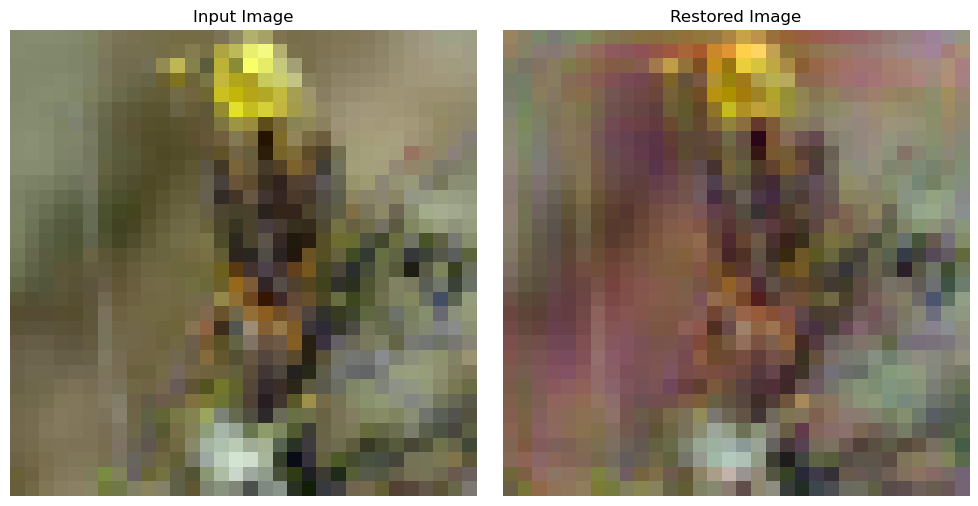

Image 2 - PSNR: 25.9279, SSIM: 0.8862, MSE: 0.0026, MAE: 0.0400, Delta E: 9.9410


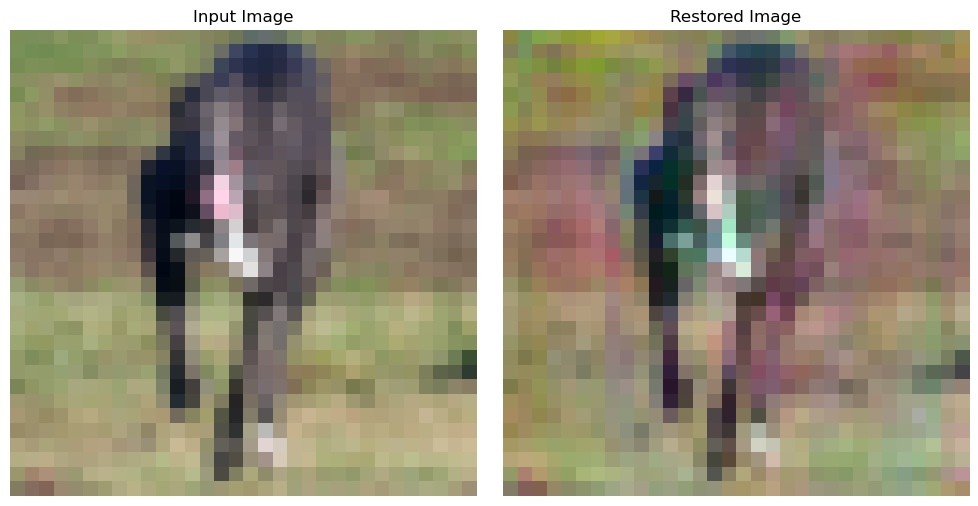

Image 3 - PSNR: 23.6616, SSIM: 0.8549, MSE: 0.0043, MAE: 0.0535, Delta E: 8.9373


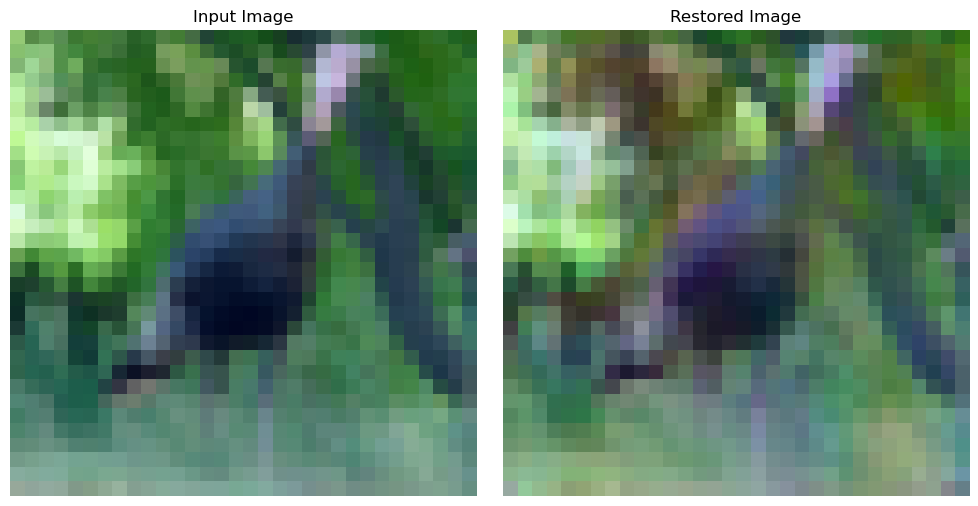

Image 4 - PSNR: 14.6913, SSIM: 0.6089, MSE: 0.0340, MAE: 0.1697, Delta E: 18.9105


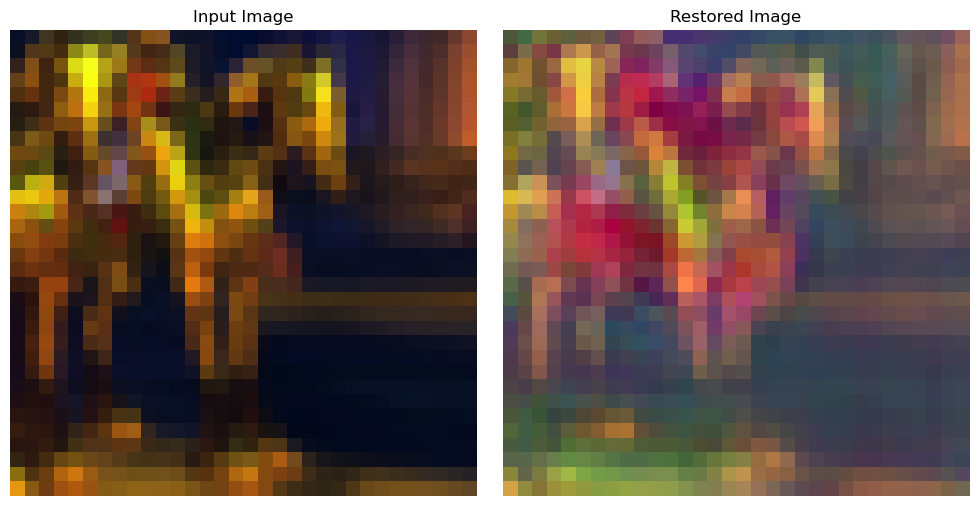

Image 5 - PSNR: 25.1604, SSIM: 0.9033, MSE: 0.0030, MAE: 0.0440, Delta E: 10.7818


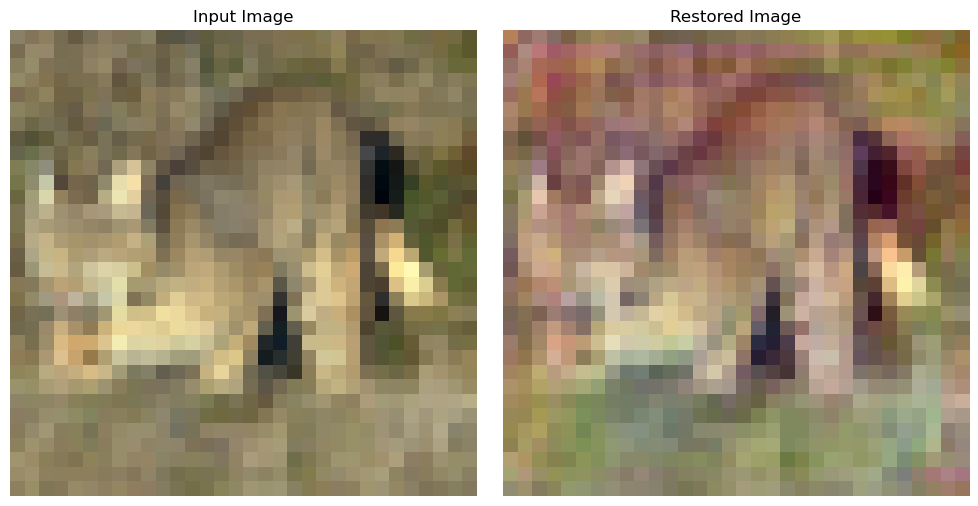

|    |   Image |    PSNR |     SSIM |        MSE |       MAE |   Delta E |
|---:|--------:|--------:|---------:|-----------:|----------:|----------:|
|  0 |       1 | 25.5713 | 0.860341 | 0.00277249 | 0.0431845 |  11.9666  |
|  1 |       2 | 25.9279 | 0.886154 | 0.00255393 | 0.0399755 |   9.94102 |
|  2 |       3 | 23.6616 | 0.854886 | 0.00430367 | 0.0535244 |   8.93727 |
|  3 |       4 | 14.6913 | 0.608934 | 0.0339521  | 0.169707  |  18.9105  |
|  4 |       5 | 25.1604 | 0.903259 | 0.00304761 | 0.0439648 |  10.7818  |


Average PSNR: 23.0025
Average SSIM: 0.8227
Average MSE: 0.0093
Average MAE: 0.0701
Average Delta E: 12.1074


In [11]:
num_images = 5
psnr_values = []
ssim_values = []
mse_values = []
mae_values = []
deltaE_values = []
results = []

for i in range(num_images):
    test_image, _ = training_set[i]
    restored_image = restored_image_func(DDPM_model, test_image, 10)

    test_image = (test_image - test_image.min()) / (test_image.max() - test_image.min())
    restored_image = (restored_image - restored_image.min()) / (restored_image.max() - restored_image.min())

    psnr_value = psnr(test_image.cpu().permute(1, 2, 0).numpy(),
                      restored_image.cpu().permute(1, 2, 0).numpy(), data_range=1.0)
    psnr_values.append(psnr_value)

    ssim_value = ssim(test_image.cpu().permute(1, 2, 0).numpy(),
                      restored_image.cpu().permute(1, 2, 0).numpy(), multichannel=True, win_size=3, data_range=1.0)
    ssim_values.append(ssim_value)

    mse_value = mse(test_image.cpu().permute(1, 2, 0).numpy(),
                    restored_image.cpu().permute(1, 2, 0).numpy())
    mse_values.append(mse_value)

    mae_value = torch.mean(torch.abs(test_image - restored_image)).item()
    mae_values.append(mae_value)

    test_image_lab = rgb2lab(test_image.cpu().permute(1, 2, 0).numpy())
    restored_image_lab = rgb2lab(restored_image.cpu().permute(1, 2, 0).numpy())
    deltaE_value = np.mean(deltaE_ciede2000(test_image_lab, restored_image_lab))
    deltaE_values.append(deltaE_value)

    print(f"Image {i+1} - PSNR: {psnr_value:.4f}, SSIM: {ssim_value:.4f}, MSE: {mse_value:.4f}, MAE: {mae_value:.4f}, Delta E: {deltaE_value:.4f}")
    

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Input Image')
    plt.axis('off')
    plt.imshow(test_image.permute(1, 2, 0))


    plt.subplot(1, 2, 2)
    plt.title('Restored Image')
    plt.axis('off')
    plt.imshow(restored_image.permute(1, 2, 0))

    plt.tight_layout()
    plt.show()

    results.append({
        "Image": i + 1,
        "PSNR": psnr_value,
        "SSIM": ssim_value,
        "MSE": mse_value,
        "MAE": mae_value,
        "Delta E": deltaE_value
    })

average_psnr = np.mean(psnr_values)
average_ssim = np.mean(ssim_values)
average_mse = np.mean(mse_values)
average_mae = np.mean(mae_values)
average_deltaE = np.mean(deltaE_values)

df = pd.DataFrame(results)

print(df.to_markdown())
print("\n")
print(f"Average PSNR: {average_psnr:.4f}")
print(f"Average SSIM: {average_ssim:.4f}")
print(f"Average MSE: {average_mse:.4f}")
print(f"Average MAE: {average_mae:.4f}")
print(f"Average Delta E: {average_deltaE:.4f}")